# Site Selection Case Study - Mexican Restaurant in the US 📍
**With the Dotlas REST API**

> by *Kunal Bhatia* [(Github)](https://github.com/kbhatia) on `2022-08-15`

<img src="https://img.shields.io/badge/python-v3.9-blue" width="80" height="80" align="left"/>
<br>

A simple notebook that can help determine places to put a Taco Bell type Mexican Restaurant in the United States. 

**This notebook uses the [Dotlas Python Package v1.0.4](https://pypi.org/project/dotlas/) which wraps around the [Dotlas REST API](https://api.dotlas.com/docs)**

* The Dotlas API provides information on *sociodemographics in the US*, along with in-depth *restaurant and culinary information* at an aggregated yet granular level. It also contains *geospatial information on cities and neighbourhoods*


* **The API can be used for a number of use-cases such as:**
    * *Competitive intelligence on restaurants in a city, neighbourhood or district*
    * *City-wide and area-wide statistics of restaurant performance*
    * *Comparing locations as a function of nearby competition and demographics*

Here, we will focus on use-case 3 to perform a site selection routine
    
The demographic information in the API is captured through the United States Census, and the restaurant information is available for upto 30 major cities. In this notebook, *we will take a top-down approach* in discovering a potential location for a mexican restaurant by using a *comparative analysis* - meaning we will measure the merits of cities, areas and locations against each other directly without performing heuristics. 

<img src="https://media.giphy.com/media/1jv9YQIX4cvtRAHVRy/giphy.gif" align="center" height="250" width="250">

In [5]:
!pip install --upgrade dotlas

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 12.4 MB 27.5 MB/s            
  Attempting uninstall: dotlas
    Found existing installation: dotlas 1.0.2
    Uninstalling dotlas-1.0.2:
      Successfully uninstalled dotlas-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires pandas!=1.0.0,!=1.0.1,!=1.0.2,!=1.1.0,>=0.25.3, which is not installed.


---

## About Site Selection 🗺

Site selection (sometimes referred to as Suitability Analysis) is the process by which a physical location is selected for a business / organization. This is done by setting some constraints and optimizing against the goal of the location. For example, in the case of a restaurant - the location may need to be in close proximity to competing restaurants in order to divert / capture the already-existing market. The location may also seek to target areas with high average income and middle-aged demographics, or other customer attributes

**In this notebook, we will not be taking a complex approach that "estimates" the best location nor magically provides the best location for a restaurant in a city from scratch. We instead seek to take a systematic approrach of asking the data yes/no questions where we compare features at different levels: `city` -> `neighbourhoods` -> `exact coordinates` and create a decision tree.**

<img src="./assets/decision_tree.png" width=700 height=700 align="center">

In [1]:
from dotenv import load_dotenv
import os

from dotlas.app import App

import numpy as np
import pandas as pd
import seaborn as sns
from shapely.geometry import Polygon

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

load_dotenv()

dot: App = App(os.getenv("DOTLAS_API_KEY"))

## City Comparison & Selection 🏙

In this section, we will compare the merits of different cities for our hypothetical mexican establishment

In [2]:
df: pd.DataFrame = pd.DataFrame(columns=['city'])
df['city'] = dot.list_cities()
df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
city,Los Angeles,Chicago,Dallas,Houston,Atlanta,New York,Philadelphia,San Francisco,Phoenix,San Diego,...,Austin,Indianapolis,Charlotte,Kansas City,Salt Lake City,Richmond,New Orleans,Providence,Oklahoma City,Raleigh


**Fetching sociodemographic stats and areas for different cities and normalizing the data frame**

In [3]:
df['stats'] = df['city'].map(lambda x: dict(dot.city_stats(x)))
df = pd.concat([df, pd.json_normalize(df['stats'], max_level=1)], axis=1).drop('stats', axis=1)
df.head(3)

,city,average_individual_income,median_household_income,population_total,population_youth,population_middle_age,population_senior,work_transportation_self_mobility,household_income_low,household_income_medium,household_income_high,households_total,households_family_total,average_household_composition
0,Los Angeles,34932.589003,76512.952881,12692752,5085250,5208620,2398882,5738163,1196010,950626,1994371,4141007,2806988,3.065137
1,Chicago,39167.917114,80078.489925,8187583,3228661,3323520,1635402,3435586,855539,681859,1478328,3015726,1944405,2.714962
2,Dallas,35333.467493,77883.630101,6212354,2675598,2549854,986902,3014712,602564,567061,1012419,2182044,1495648,2.847034


Assuming Youth Population could be our target customer base, we can see the distribution of youth vs total population. Selecting cities based on the assumption a taco bell type mexican restaurant is popular among the younger population demographic

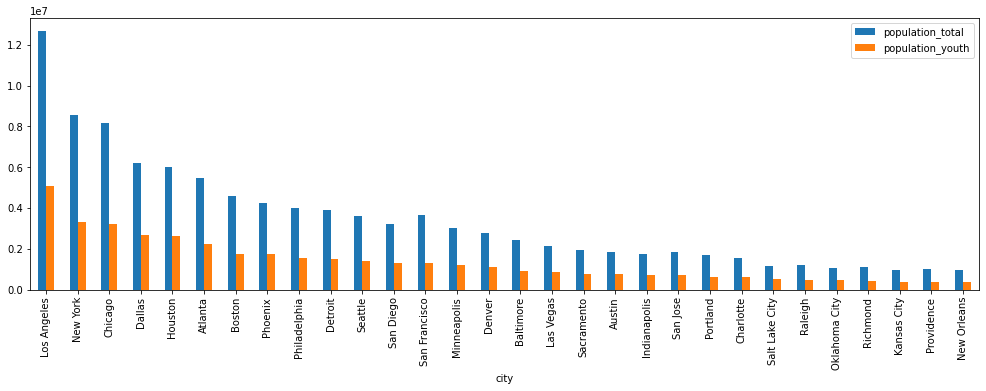

In [4]:
df.sort_values(by=['population_youth'], ascending=False).set_index('city')[
    ['population_total', 'population_youth']
].plot(kind='bar', figsize=(17,5));

In [5]:
# normalizing youth population
df['normalized_population_youth'] = (
    df['population_youth'] - df['population_youth'].mean()
)/df['population_youth'].std()

# Sorting values according the population of young people and selecting top 6 cities
df = df.sort_values(['normalized_population_youth'], ascending=False).reset_index(drop=True)

df.head(6)[
    ['city', 'population_total', 'population_youth', 'normalized_population_youth']
].set_index('city').style.format(
    {"population_total" : '{:,}', 'population_youth' : '{:,}','normalized_population_youth' : '{:.2f}'}
).background_gradient(cmap="viridis")

,population_total,population_youth,normalized_population_youth
city,,,
Los Angeles,"12,692,752","5,085,250",3.39
New York,"8,558,903","3,317,217",1.78
Chicago,"8,187,583","3,228,661",1.70
Dallas,"6,212,354","2,675,598",1.19
Houston,"6,017,643","2,634,484",1.16
Atlanta,"5,478,959","2,252,676",0.81


## Area (Neighbourhood) Comparison & Selection 🏘

Areas/Neighbourhoods are the city-specific locales that partition the entire metropolis into a set of living / industrial / tourist segments. Here's an example for Manhattan, New York. Image Source: Pinterest.

<img src="https://i.pinimg.com/originals/4f/2c/82/4f2c829e49c04aa7dc8f9fc7e4969d33.png" height="200" width="200">



In [6]:
# Creating a new dataframe for selecting areas in 6 selected cities
df_areas: pd.DataFrame = df[['city']].copy()
df_areas = df_areas.head(6)

def get_areas_in_city(x: pd.Series) -> str:
    try:
        return dot.list_areas_in_city(x['city'])
    except:
        return np.nan

# Fetching areas for different cities and assigning them per city
df_areas['area'] = df_areas.apply(get_areas_in_city, axis=1)
df_areas = df_areas.dropna().reset_index(drop=True)
df_areas = df_areas.explode('area').reset_index(drop=True)
df_areas.transpose()

,0,1,2,3,4,5,6,7,8,9,...,635,636,637,638,639,640,641,642,643,644
city,Los Angeles,Los Angeles,Los Angeles,Los Angeles,Los Angeles,Los Angeles,Los Angeles,Los Angeles,Los Angeles,Los Angeles,...,Atlanta,Atlanta,Atlanta,Atlanta,Atlanta,Atlanta,Atlanta,Atlanta,Atlanta,Atlanta
area,Adams Hill,Brockmont,Chevy Chase,Citrus Grove,Pacific Edison,City Center,College Hills,El Miradero,Emerald Isle,Fremont Park,...,Center Hill,Adams Park,Adair Park,Morningside-Lenox Park,Edgewood-Kirkwood,Downtown,Oakdale,Candler Park,Poncey-Highland,Cabbage Town


Number of areas per city

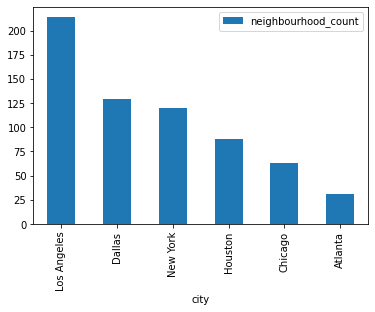

In [7]:
df_areas.groupby('city')[['area']].count().sort_values(by=['area'], ascending=False).rename(
    columns={'area' : 'neighbourhood_count'}
).plot(kind='bar');

**Fetch Stats per Area for all selected cities**

In [8]:
from tqdm import tqdm
tqdm.pandas()

def get_area_stats(x):
    try:
        return dict(
            dot.area_stats(
                x['city'], x['area']
            )
        )
    except:
        return np.nan

# Getting area stats for different areas
df_areas['stats'] = df_areas.progress_apply(get_area_stats, axis=1)
df_areas = df_areas.dropna().reset_index(drop=True)
df_areas.sample(3)

100%|██████████| 645/645 [03:52<00:00,  2.77it/s]


,city,area,stats
312,New York,Brownsville,{'sociodemographic': demographics=Demographics...
231,New York,Baychester,{'sociodemographic': demographics=Demographics...
314,New York,Upper West Side,{'sociodemographic': demographics=Demographics...


In [9]:
df_areas: pd.DataFrame = pd.concat(
    [df_areas, pd.json_normalize(df_areas['stats'], max_level=1)], axis=1
).drop('stats', axis = 1)
df_areas.head(3)

,city,area,sociodemographic,areas_covered,geometry
0,Los Angeles,Adams Hill,demographics=Demographics(total_population=Gen...,[Adams Hill],type='FeatureCollection' features=[GeometryFea...
1,Los Angeles,Brockmont,demographics=Demographics(total_population=Gen...,[],type='FeatureCollection' features=[GeometryFea...
2,Los Angeles,Chevy Chase,demographics=Demographics(total_population=Gen...,[],type='FeatureCollection' features=[GeometryFea...


In [10]:
df_areas = df_areas.drop('areas_covered', axis=1)

# Converting sociodemographic column to dicts and normalizing the dataframe
df_areas['sociodemographic'] = df_areas['sociodemographic'].map(lambda x: dict(x))
df_areas = pd.concat(
    [df_areas, pd.json_normalize(df_areas['sociodemographic'], max_level=1)], axis=1
).drop('sociodemographic', axis=1)

# Converting demographics columns to dicts and normalizing the dataframe
df_areas['demographics'] = df_areas['demographics'].map(lambda x: dict(x))
df_areas = pd.concat(
    [df_areas, pd.json_normalize(df_areas['demographics'],max_level=1)], axis=1
).drop('demographics', axis=1)

df_areas.head(3)

,city,area,geometry,income,household_composition,total_population,youth_population,middle_aged_population,senior_population,self_mobilizing_population,population_affluence
0,Los Angeles,Adams Hill,type='FeatureCollection' features=[GeometryFea...,"household=IncomeStatistical(avg=None, median=G...",household_count=GeneralStatisitcal(value=4688....,value=11820.0 city=12692752.0 share=0.0,value=3918.0 city=5085250.0 share=0.0,value=5007.0 city=5208620.0 share=0.0,value=2895.0 city=2398882.0 share=0.0,value=5697.0 city=5738163.0 share=0.0,low_median_household_income=GeneralStatisitcal...
1,Los Angeles,Brockmont,type='FeatureCollection' features=[GeometryFea...,"household=IncomeStatistical(avg=None, median=G...",household_count=GeneralStatisitcal(value=2980....,value=8225.0 city=12692752.0 share=0.0,value=2520.0 city=5085250.0 share=0.0,value=3266.0 city=5208620.0 share=0.0,value=2439.0 city=2398882.0 share=0.0,value=3391.0 city=5738163.0 share=0.0,low_median_household_income=GeneralStatisitcal...
2,Los Angeles,Chevy Chase,type='FeatureCollection' features=[GeometryFea...,"household=IncomeStatistical(avg=None, median=G...",household_count=GeneralStatisitcal(value=5707....,value=15666.0 city=12692752.0 share=0.0,value=4739.0 city=5085250.0 share=0.0,value=6179.0 city=5208620.0 share=0.0,value=4748.0 city=2398882.0 share=0.0,value=6855.0 city=5738163.0 share=0.0,low_median_household_income=GeneralStatisitcal...


In [11]:
# Normalizing youth population and self mobilizing population for different areas
df_areas['normalized_population_youth'] = df_areas.apply(lambda x: x['youth_population'].value, axis=1)

df_areas['normalized_population_youth'] = (
    df_areas['normalized_population_youth'] - df_areas['normalized_population_youth'].mean()
)/df_areas['normalized_population_youth'].std()

df_areas['normalized_self_mobilizing_population'] = df_areas.apply(
    lambda x: x['self_mobilizing_population'].value, axis=1
)

df_areas['normalized_self_mobilizing_population'] = (
    df_areas['normalized_self_mobilizing_population']-df_areas['normalized_self_mobilizing_population'].mean()
)/df_areas['normalized_self_mobilizing_population'].std()

# Sorting data frame according the normalized youth population and normalized self mobilizing population
df_areas = df_areas.sort_values(
    ['normalized_self_mobilizing_population','normalized_population_youth'],
    ascending=[False,False]
).reset_index(drop=True)

df_areas.head(3)

,city,area,geometry,income,household_composition,total_population,youth_population,middle_aged_population,senior_population,self_mobilizing_population,population_affluence,normalized_population_youth,normalized_self_mobilizing_population
0,Dallas,Northeast Dallas,type='FeatureCollection' features=[GeometryFea...,"household=IncomeStatistical(avg=None, median=G...",household_count=GeneralStatisitcal(value=12011...,value=300539.0 city=6212354.0 share=0.05,value=130372.0 city=2675598.0 share=0.05,value=123700.0 city=2549854.0 share=0.05,value=46467.0 city=986902.0 share=0.05,value=149063.0 city=3014712.0 share=0.05,low_median_household_income=GeneralStatisitcal...,5.244240,7.529631
1,Dallas,Far North,type='FeatureCollection' features=[GeometryFea...,"household=IncomeStatistical(avg=None, median=G...",household_count=GeneralStatisitcal(value=98421...,value=224063.0 city=6212354.0 share=0.04,value=95535.0 city=2675598.0 share=0.04,value=93037.0 city=2549854.0 share=0.04,value=35491.0 city=986902.0 share=0.04,value=126670.0 city=3014712.0 share=0.04,low_median_household_income=GeneralStatisitcal...,3.612029,6.263729
2,Los Angeles,South Los Angeles,type='FeatureCollection' features=[GeometryFea...,"household=IncomeStatistical(avg=None, median=G...",household_count=GeneralStatisitcal(value=93692...,value=324335.0 city=12692752.0 share=0.03,value=157058.0 city=5085250.0 share=0.03,value=119877.0 city=5208620.0 share=0.02,value=47400.0 city=2398882.0 share=0.02,value=116682.0 city=5738163.0 share=0.02,low_median_household_income=GeneralStatisitcal...,6.494554,5.699095


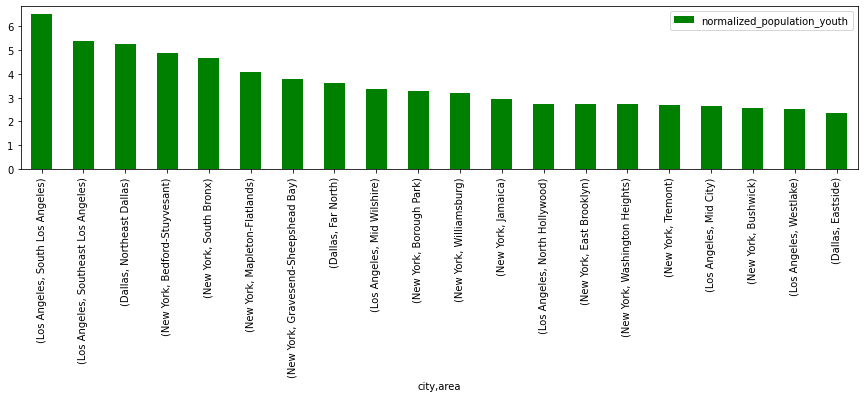

In [12]:
df_areas.sort_values(by=['normalized_population_youth'], ascending=False).set_index(['city', 'area'])[
    ['normalized_population_youth']
].head(20).plot(kind='bar', figsize=(15,3), color="green");


In [13]:
def get_centroid_of_area(x: pd.Series):
    try:
        return Polygon(np.array(x['geometry'].features[0].geometry.coordinates[0])).centroid
    except:
        return np.nan

df_areas['centroid'] = df_areas.apply(get_centroid_of_area, axis=1)
df_areas = df_areas.dropna().reset_index(drop=True)
df_areas[['city','area','geometry','centroid']].head(3)

,city,area,geometry,centroid
0,Dallas,Northeast Dallas,type='FeatureCollection' features=[GeometryFea...,POINT (-96.71437870676374 32.84507150705269)
1,Dallas,Far North,type='FeatureCollection' features=[GeometryFea...,POINT (-96.80346238927793 32.97433026330851)
2,Los Angeles,South Los Angeles,type='FeatureCollection' features=[GeometryFea...,POINT (-118.29781452181662 33.98860286401065)


**Filter for top 30 locations**

In [19]:
df_areas = df_areas.sort_values(by=['normalized_population_youth'], ascending=False).reset_index(drop=True)
df_areas = df_areas.head(30)

Get Nearby Restaurant Competition for Area 

In [22]:
def get_competition_stats_of_area(x: pd.Series):
    try:
        return dot.nearby_competition(
            x['centroid'].coords[0][1], 
            x['centroid'].coords[0][0], 
            x['city'], 
            commercial_type="Restaurant"
        ).response.data.top_occurring_categories
    except:
        return np.nan

df_areas['tags'] = df_areas.progress_apply(get_competition_stats_of_area,axis=1)
df_areas = df_areas.dropna().reset_index(drop=True)
df_areas = df_areas[~df_areas['tags'].apply(lambda x: 'Mexican' in x)].reset_index(drop=True)

100%|██████████| 30/30 [00:09<00:00,  3.18it/s]


In [ ]:
##TBC